# **Download libraries**

In [ ]:
!pip install tensorboardX
!pip install -q evaluate seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268

# **Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
import torchvision
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from datetime import datetime
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import cv2
import math
import os
import numpy as np
from tqdm.auto import tqdm
import evaluate
import pandas as pd
from torchvision.models import resnet50
import time
import copy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
# switch to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Mounted at /gdrive


device(type='cuda')

# **Load dataset**

In [ ]:
#train and test data directory
data_dir = "/gdrive/MyDrive/data/train_resnet/train/"
test_data_dir = "/gdrive/MyDrive/data/train_resnet/test/"

#load the train and test data with augmentation
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),

]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor()
]))

In [ ]:
batch_size = 10
val_size = 500
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
#load the train and validation into batches.
train_loader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 5063
Length of Validation Data : 500


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
data_loader = {"train" : train_loader, "val" : val_loader}

# **Train epochs**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []

    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            elif phase == 'train' :
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, {'val_acc' : val_acc_history, 'val_loss' : val_loss_history, 'train_acc' : train_acc_history, 'train_loss' : train_loss_history}

# **Set parameters**

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

model_ft = resnet50(weights=None)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224
criterion = nn.CrossEntropyLoss()

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

# **Let's train !**

In [ ]:
criterion = nn.CrossEntropyLoss()
model, history = train_model(model_ft, data_loader, criterion, optimizer_ft, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.2383 Acc: 0.5288
val Loss: 1.0491 Acc: 0.7300

Epoch 1/14
----------
train Loss: 0.7694 Acc: 0.7351
val Loss: 0.7275 Acc: 0.8040

Epoch 2/14
----------
train Loss: 0.5352 Acc: 0.8118
val Loss: 1.4352 Acc: 0.6660

Epoch 3/14
----------
train Loss: 0.4671 Acc: 0.8395
val Loss: 0.7606 Acc: 0.7700

Epoch 4/14
----------
train Loss: 0.4097 Acc: 0.8571
val Loss: 0.5751 Acc: 0.8780

Epoch 5/14
----------
train Loss: 0.3289 Acc: 0.8841
val Loss: 1.3469 Acc: 0.7880

Epoch 6/14
----------
train Loss: 0.3039 Acc: 0.8982
val Loss: 0.4626 Acc: 0.9000

Epoch 7/14
----------
train Loss: 0.2645 Acc: 0.9076
val Loss: 4.0513 Acc: 0.4580

Epoch 8/14
----------
train Loss: 0.1989 Acc: 0.9312
val Loss: 3.3613 Acc: 0.5320

Epoch 9/14
----------
train Loss: 0.1903 Acc: 0.9338
val Loss: 0.2549 Acc: 0.9140

Epoch 10/14
----------
train Loss: 0.1866 Acc: 0.9342
val Loss: 0.3446 Acc: 0.8960

Epoch 11/14
----------
train Loss: 0.1846 Acc: 0.9347
val Loss: 0.5154 Acc: 0.8400

Ep

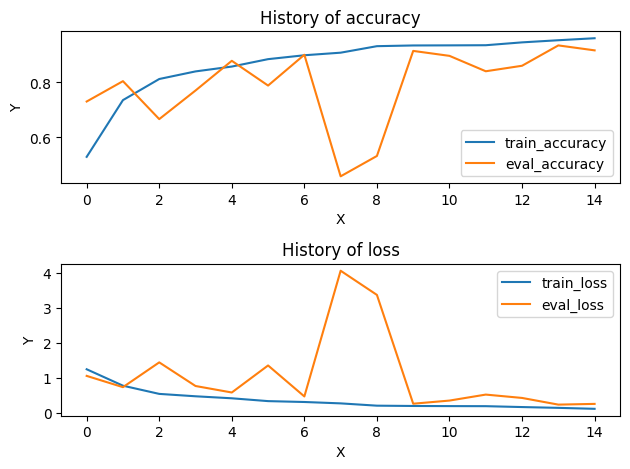

In [ ]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2)

train_acc = torch.Tensor(history["train_acc"]).cpu().data.numpy()
train_loss = torch.Tensor(history["train_loss"]).cpu().data.numpy()

val_acc = torch.Tensor(history["val_acc"]).cpu().data.numpy()
val_loss = torch.Tensor(history["val_loss"]).cpu().data.numpy()

# Plot lines on the first subplot
ax1.plot(train_acc, label='train_accuracy')
ax1.plot(val_acc, label='eval_accuracy')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('History of accuracy')
ax1.legend()

# Plot lines on the second subplot
ax2.plot(train_loss, label='train_loss')
ax2.plot(val_loss, label='eval_loss')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('History of loss')
ax2.legend()

# Adjust the layout of the subplots
plt.tight_layout()

# Display the figure
plt.show()

# **Evaluation**

In [ ]:
def eval_model(model, dataloaders, criterion, optimizer):
    since = time.time()
    all_pred = []
    all_label = []

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        all_label.extend(labels.squeeze())
        all_pred.extend(preds)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    all_label = torch.stack(all_label, dim=0)
    all_pred = torch.stack(all_pred, dim=0)

    epoch_loss = running_loss / len(dataloaders.dataset)
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)

    print('test Loss: {:.4f} Acc: {:.4f}'.format( epoch_loss, epoch_acc))

    val_acc_history.append(epoch_acc)

    print()

    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print()
    # Classification report
    print('\n\n\t\tCLASSIFICATIION METRICS\n')
    print(metrics.classification_report(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy(),
                                        target_names = ["handwritten", "other", "table"]))
    return metrics.classification_report(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy(),
                                        target_names = ["handwritten", "other", "table"], output_dict=True)

In [ ]:
accuracy = eval_model(model, test_loader, criterion, optimizer_ft)

test Loss: 0.2799 Acc: 0.9288

Test complete in 0m 11s



		CLASSIFICATIION METRICS

              precision    recall  f1-score   support

 handwritten       0.95      0.97      0.96       556
       other       0.92      0.90      0.91       515
       table       0.91      0.91      0.91       501

    accuracy                           0.93      1572
   macro avg       0.93      0.93      0.93      1572
weighted avg       0.93      0.93      0.93      1572



# **Save the modele**

In [ ]:
torch.save(model, "/gdrive/MyDrive/saved_models/resnet_pytorch/resnet_model_nlp_state2.pth")

In [ ]:
modelB = torch.load("/gdrive/MyDrive/saved_models/resnet_pytorch/resnet_model_nlp_state2.pth", map_location=device)

In [ ]:
torch.save(model.state_dict(), "/gdrive/MyDrive/saved_models/resnet_pytorch/resnet_model_nlp_state_dict2.pth")

In [ ]:
modelC = torch.load("/gdrive/MyDrive/saved_models/resnet_pytorch/resnet_model_nlp_state_dict2.pth", map_location=device)

In [ ]:
def eval_model_pred(model, dataloaders, criterion, optimizer):
    all_pred = []
    all_label = []

    model.eval()   # Set model to evaluate mode

    # Iterate over data.
    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_pred.extend(preds)
        all_label.extend(labels.cpu().numpy())

    return all_label, all_pred

criterion = nn.CrossEntropyLoss()
original_labels, all_pred = eval_model_pred(modelB, test_loader, criterion, optimizer_ft)

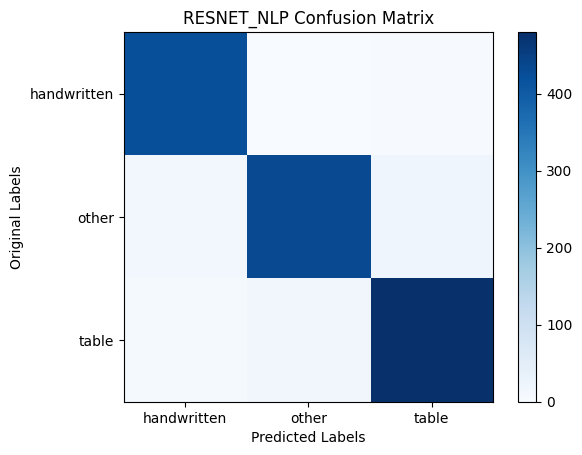

In [ ]:
cm = confusion_matrix(torch.Tensor(original_labels).cpu(), torch.Tensor(all_pred).cpu())

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("RESNET_NLP Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("Original Labels")
plt.xticks(np.arange(len(np.unique(["handwritten", "other", "table"]))), np.unique(["handwritten", "other", "table"]))
plt.yticks(np.arange(len(np.unique(["handwritten", "other", "table"]))), np.unique(["handwritten", "other", "table"]))
plt.show()

# **Inference**

In [ ]:
time_start = time.time()
model.eval()
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),

])

image_path = "/gdrive/MyDrive/test_images/receipt7.jpg"
image = Image.open(image_path)
channels = transforms.ToTensor()(image)
if channels.shape[0]>3 or channels.shape[0]<3:
    image = image.convert(mode='RGB')
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)


with torch.no_grad():
    output = modelB(input_batch.to(device))
    predictions = output[0]
    _, predicted_idx = torch.max(output, 1)
model_labels = ["handwritten", "other", "table"]

class_table = {}
for i in range(len(model_labels)):
    class_table[model_labels[i]] = str(int(predictions[i] * 10)) + "%"
time_end = time.time()
predicted_label = model_labels[predicted_idx.item()]
#print(class_table)
#print("execution time : ", time_end - time_start)
predicted_label

'other'